In [1]:
from dataset.k_fold_dataset_wrapper import KFoldDatasetWrapper
from torch.utils.data import DataLoader
from dataset.dataset_loader import dataset_loader

# What image size? Let's go for a common image size while allowing the network to be smaller:
# 160x160: A bit larger than 128x128, this size provides slightly more detail while still maintaining reasonable computational requirements. It's suitable for various tasks, including object detection and classification.
train, test = dataset_loader((160, 160), is_grayscale=False)

# We take 20% of dataset as validation.
dataset_split_controller = KFoldDatasetWrapper(5)
dataset_split_controller.load_data(train)

local_train, validation = dataset_split_controller.get_data_for_fold(0)

train_dataloader = DataLoader(dataset=local_train, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(dataset=validation, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test, batch_size=32, shuffle=True)

In [2]:
print(f"Validation set is {len(validation) / (len(train) + len(test)) * 100:.2f}% of total dataset.")

Validation set is 16.00% of total dataset.


In [3]:
from models.structure.learning_parameters.sgd_learning_parameters import SgdLearningParameters
from models.naive_dnn_gen.naive_dnn import NaiveDnnWrapper

# For input of size 160x160x3 (150528) we have the problem to choose the neurons between that and 1 (output).
# It would be reasonable to have large hidden layers. Yet we are limited.
model = NaiveDnnWrapper().make_model((3, 160, 160))

learning_parameters = SgdLearningParameters(learning_rate=1e-4)
learning_parameters.compile_model(model)

model.summary()

OutOfMemoryError: CUDA out of memory. Tried to allocate 600.00 MiB. GPU 0 has a total capacity of 7.75 GiB of which 606.44 MiB is free. Process 10476 has 1.41 GiB memory in use. Process 15452 has 1.71 GiB memory in use. Process 16133 has 2.48 GiB memory in use. Including non-PyTorch memory, this process has 184.00 MiB memory in use. Of the allocated memory 0 bytes is allocated by PyTorch, and 0 bytes is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

I don't know why but it considers 16 for batch size while I didn't explicit it.

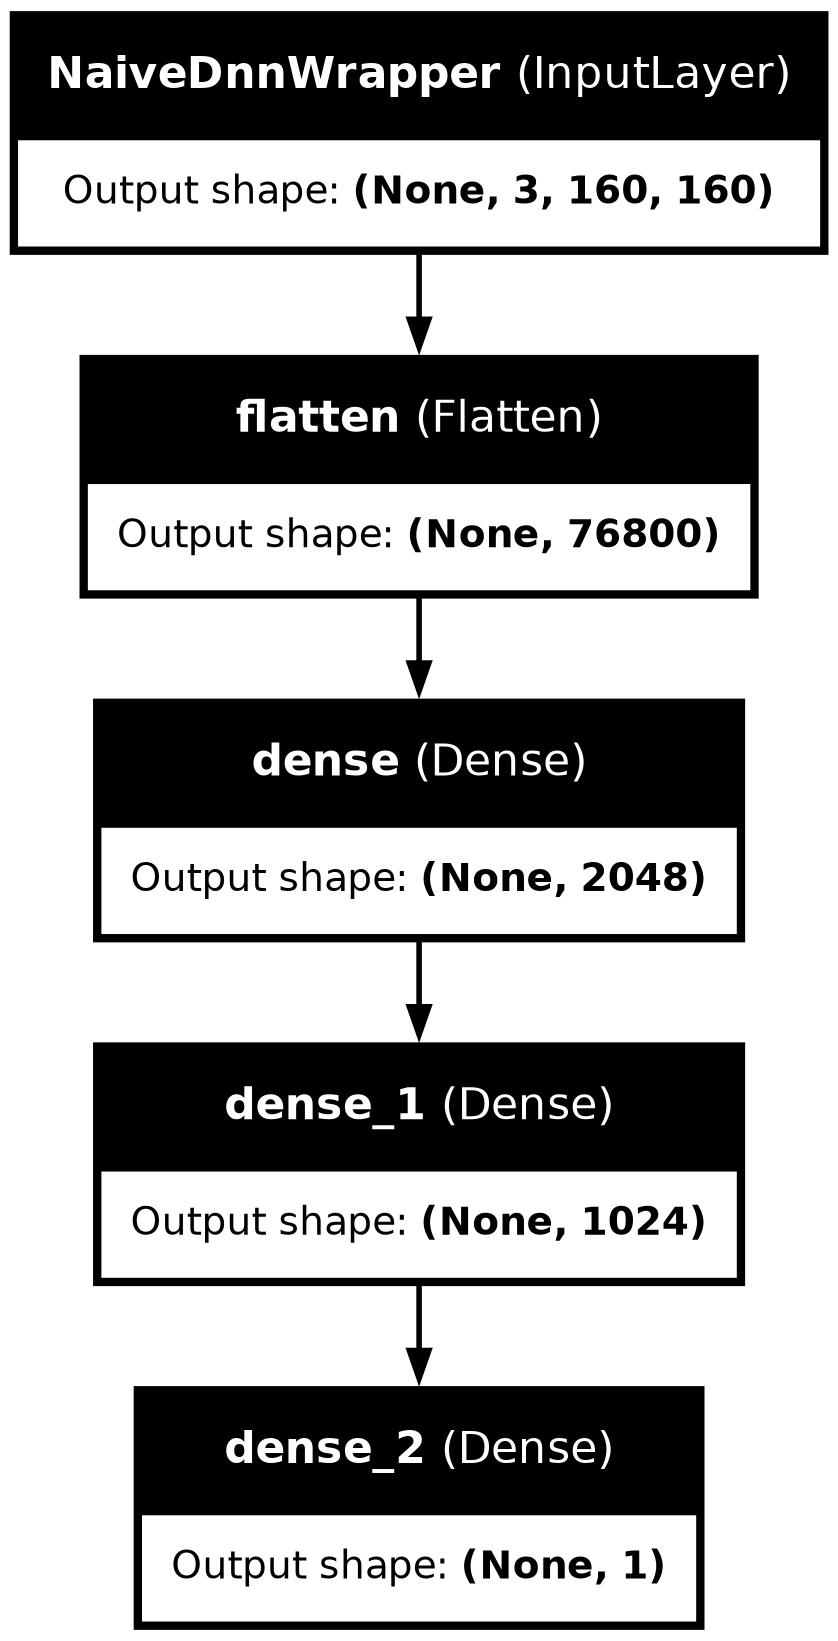

In [4]:
import keras

keras.utils.plot_model(
    model, to_file='hand_tailored_conv_net.png', show_layer_names=True, expand_nested=True, show_shapes=True
)

In [5]:
import keras

# In this simple approach we have fixed [Train 0.8 - Val 0.2 - Test] without doing any k-fold CV.
# The number of epoches is fixed by early stopping. (In the case of k-fold-CV it will be a hp given by average performance?)
history = model.fit(x=train_dataloader, validation_data=validation_dataloader, batch_size=32, epochs=120, callbacks=[
    # To avoid going further when training
    keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=10,
        verbose=1, mode='min', restore_best_weights=True
    ),
    # To persist the history
    keras.callbacks.CSVLogger(f"hand-tailored-dnn.log", separator=",", append=True)
])

Epoch 1/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.6237 - loss: 0.6429 - val_accuracy: 0.7276 - val_loss: 0.5533
Epoch 2/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.7282 - loss: 0.5489 - val_accuracy: 0.7107 - val_loss: 0.5523
Epoch 3/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.7437 - loss: 0.5140 - val_accuracy: 0.7614 - val_loss: 0.5090
Epoch 4/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 375ms/step - accuracy: 0.7848 - loss: 0.4760 - val_accuracy: 0.7730 - val_loss: 0.4933
Epoch 5/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - accuracy: 0.8019 - loss: 0.4533 - val_accuracy: 0.7107 - val_loss: 0.5584
Epoch 6/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.7943 - loss: 0.4422 - val_accuracy: 0.7476 - val_loss: 0.5364
Epoch 7/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 382ms/step - accuracy: 0.8241 - loss: 0.4169 - val_accuracy: 0.7782 - val_loss: 0.4808
Epoch 8/120
119/119 ━━━━━━━━━━━━━━━━━━━━ 45s 378ms/step - accuracy: 0.8164 -

In [7]:
res = model.evaluate(test_dataloader)
persist_model: bool = True

# We don't want to persist the model as I already saved it.
if persist_model:
    model.save('hand_tailored_dnn_net.keras')

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.7864 - loss: 0.4825


2024-05-09 10:21:13.471330: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 10:21:13.667640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 10:21:14.413576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
print(f"Test accuracy is {res[1] * 100:.2f}% while loss is {res[0]}")
print(f"The model is not that bad considering we have no pre-processing done and the parameters were chosen freely")

Test accuracy is 78.97% while loss is 0.4713054299354553
The model is not that bad considering we have no pre-processing done and the parameters were chosen freely


In [9]:
import pandas

csv = pandas.read_csv(f"hand-tailored-dnn.log")

In [13]:
import plotly.express as px

loss_figure = px.line(csv, x="epoch", y=["loss", "val_loss"], template="plotly_white", markers=True)
loss_figure.update_layout(title="Loss", xaxis_title="Epoch", yaxis_title="Loss")

In [12]:
figure = px.line(csv, x="epoch", y=["accuracy", "val_accuracy"], template="plotly_white", markers=True)
figure.update_layout(title="Accuracy", xaxis_title="Epoch", yaxis_title="Loss")

The model isn't necessarily evil. It works fair enough not being tuned.
Regularization and images pre-processing could lead to some good results while maybe it is the case to increase the parameters? All these considerations are to left to thought as the CNN (which is a state of the art approach) is only 1/3 of the current network and performs consistently better in the same amount of epochs on test while having more trouble fitting the training set.

### CNN seem to be the path to take (as tweaking a DNN can be a really hard task)